<a href="https://colab.research.google.com/github/impoxeur2001/Sentiment_Analysis_Darija/blob/main/Untitled0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**NOTEBOOK SETUP**

In [1]:
pip install transformers


Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install pyarabic

Note: you may need to restart the kernel to use updated packages.


In [3]:
from operator import length_hint 
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
import copy
from torch import nn, optim
from torch.utils import data
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModel, AdamW, get_linear_schedule_with_warmup

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
import codecs
from sklearn.preprocessing import LabelEncoder

In [5]:
from torch.utils.data import Dataset, DataLoader

In [6]:
from collections import defaultdict

In [7]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
pip install aaransia

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
  Created wheel for aaransia: filename=aaransia-1.1-py3-none-any.whl size=45744 sha256=67347845f6dc6908bfeda084ff66ecf5f6bedc95379f9f1434c1405176ae0338
  Stored in directory: /root/.cache/pip/wheels/e6/d5/29/a98fd21f664d13c162b8fda3b2aa23a777b26377f23db60b03
Successfully built aaransia
Note: you may need to restart the kernel to use updated packages.


In [9]:
from aaransia import transliterate 


In [10]:
import string
import re
from pyarabic.araby import strip_tatweel,strip_tashkeel

**DATA EXPLORATION**

In [11]:
df= pd.read_csv('/kaggle/input/dataset-darija-1/dataset_darija_1.csv', on_bad_lines='skip', sep = ';')
df.columns = ['sentiment','sentence']
df.describe()
df.head()
df['sentiment'] = df['sentiment'].str.replace(" ", "")
df['sentiment'] = df['sentiment'].str.rstrip()

In [12]:
le=LabelEncoder()
df['sentiment']= le.fit_transform(df['sentiment'])
df=df[df['sentiment']!=2]

In [13]:
df['sentiment'].value_counts()

1    1031
0    1021
Name: sentiment, dtype: int64

Text(0.5, 0, 'sentiment')

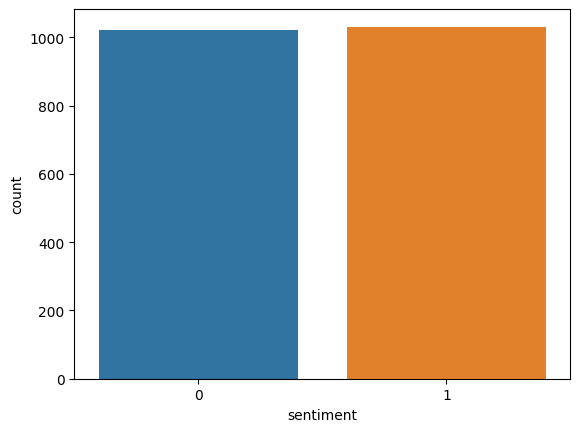

In [14]:
sns.countplot(df, x='sentiment')
plt.xlabel('sentiment')

In [15]:
class_values=[0,1]

**PREPROCESSING**

In [16]:

DarijaBERT_tokenizer = AutoTokenizer.from_pretrained("SI2M-Lab/DarijaBERT")
DarijaBert_model = AutoModel.from_pretrained("SI2M-Lab/DarijaBERT")

The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.


The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.


Some weights of the model checkpoint at SI2M-Lab/DarijaBERT were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [17]:
def repted(text):
    text=re.sub(r'(.)\1+', r'\1', text)# Replace with only one (remove repetitions)  
    return text

In [18]:
def get_emojis():
    with codecs.open("emoji.txt", "r", encoding="utf-8", errors="ignore") as myfile:
         positive_emoji=myfile.read()
    positive_emoji=positive_emoji.split("\r\n")
    positive_emoji=positive_emoji[1:len(positive_emoji)-1] 
    with codecs.open("neg_emoji.txt", "r", encoding="utf-8", errors="ignore") as myfie:
        neg_emoji=myfie.read()
    neg_emoji=neg_emoji.split("\r\n")
    neg_emoji=neg_emoji[1:len(neg_emoji)-1]
    return positive_emoji,neg_emoji

In [19]:
def emoji_to_text(text):
    text_words = []
    words = text.split(" ")
    positive_emoji,neg_emoji=get_emojis()
    for word in words:
        if emoji_pattern.search(word):
            if word in positive_emoji :
                word='ايجابي'
            if word in neg_emoji :
                word='سلبي'
        text_words.append(word)
    return ' '.join(text_words)

In [20]:
def remove_emojis(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)

In [21]:
def strip_links(text):
    link_regex    = re.compile('((https?):((//)|(\\\\))+([\w\d:#@%/;$()~_?\+-=\\\.&](#!)?)*)', re.DOTALL)
    links         = re.findall(link_regex, text)
    for link in links:
        text = text.replace(link[0], ', ')
    return text

In [22]:
def pre_processing(df,source,field):
    df[field] = df[source]
    df[field] = strip_links(df[field]) # remove links
    df[field] = emoji_to_text(df[field]) # replace emojies with their sentiments
    df[field] = df[field].replace(r'@[^\s]+', 'USER', regex=True) # Replace user mentions with USER string
    df[field] = df[field].replace(r'#[^\s]+', 'HASHTAG', regex=True) # Replace Hashtags with HASHTAG string
    df=df[df[field].apply(lambda x:len(re.findall(r'[\u0600-\u06FF]+', x)))>1] #Keep sequences with at least 2 arabic words
    df[field] = df[field].apply(strip_tatweel) #Remove Tatweel string 
    df[field] = df[field].apply(strip_tashkeel) # Remove Diacritics
    df[field] = df[field].apply(repted)
    return df

In [23]:
sample_txt= "ch7al zwina dnia"
sample_txt_ar=transliterate(sample_txt, source='ma', target='ar', universal=True)
tokens = DarijaBERT_tokenizer.tokenize(sample_txt_ar)
token_ids = DarijaBERT_tokenizer.convert_tokens_to_ids(tokens)
print(f' Sentence: {sample_txt_ar}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: شحال زوينا دنيا
   Tokens: ['شحال', 'زوينا', 'دنيا']
Token IDs: [2448, 22504, 4236]


In [24]:
encoding = DarijaBERT_tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  truncation=True,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)
encoding.keys()

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


dict_keys(['input_ids', 'attention_mask'])

In [25]:
encoding['input_ids']

tensor([[    2,  8094,  1041,  3630, 56472,    48, 19829,  1058,     3,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0]])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


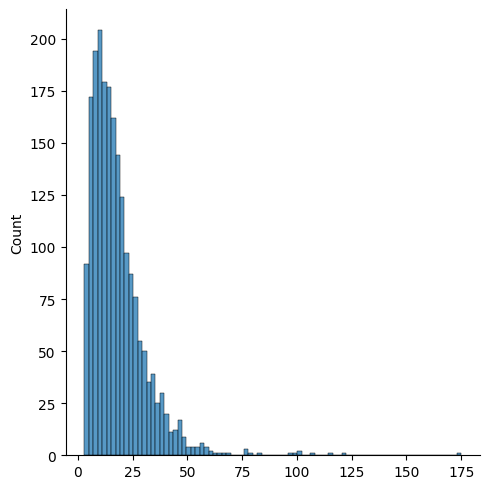

In [26]:
token_lens=[]

for txt in df.sentence:
  encodings=DarijaBERT_tokenizer.encode(txt,max_length=512)
  var=length_hint(encodings)
  token_lens.append(var)
sns.displot(token_lens)  

**Creat a Pytorch Dataset**

In [27]:
class GPSentenceDataset(Dataset):
  def __init__(self, sentences, targets, tokenizer, max_len):
    self.sentences = sentences
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  def __len__(self):
    return len(self.sentences)
  def __getitem__(self, item):
    sentence = str(self.sentences[item])
    target = self.targets[item]
    encoding = self.tokenizer.encode_plus(
      sentence,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )
    input_ids = torch.tensor(encoding['input_ids'], dtype=torch.long)
    attention_mask = torch.tensor(encoding['attention_mask'], dtype=torch.long)
    return {
      'sentence_text': sentence,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [28]:
for sentence in df.sentence:
  sentence= remove_emojis(sentence)

**SPLIT THE DATASET**


In [29]:
df_train, df_test = train_test_split(
  df,
  test_size=0.1,
  random_state=RANDOM_SEED
)
df_val, df_test = train_test_split(
  df_test,
  test_size=0.5,
  random_state=RANDOM_SEED
)

**Creat Data Loaders**

In [30]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPSentenceDataset(
    sentences=df.sentence.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )
  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=1
  )

In [31]:
BATCH_SIZE = 16
MAX_LEN = 180
train_data_loader = create_data_loader(df_train, DarijaBERT_tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, DarijaBERT_tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, DarijaBERT_tokenizer, MAX_LEN, BATCH_SIZE)

In [32]:
ds = GPSentenceDataset(
    sentences=df.sentence.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=DarijaBERT_tokenizer,
    max_len=MAX_LEN
  )


In [33]:
df.dtypes


sentiment     int64
sentence     object
dtype: object

In [34]:
data = next(iter(train_data_loader))
data.keys()


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/tmp/ipykernel_20/3943356482.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(encoding['input_ids'], dtype=torch.long)
/tmp/ipykernel_20/3943356482.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().re

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


dict_keys(['sentence_text', 'input_ids', 'attention_mask', 'targets'])

In [35]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 180])
torch.Size([16, 180])
torch.Size([16])


In [36]:
last_hidden_state, pooled_output = DarijaBert_model(
  input_ids=encoding['input_ids'],
  attention_mask=encoding['attention_mask']
)

In [37]:
DarijaBert_model.config


BertConfig {
  "_name_or_path": "SI2M-Lab/DarijaBERT",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "cls_token": "[CLS]",
  "do_lower_case": true,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "mask_token": "[MASK]",
  "max_len": 128,
  "max_position_embeddings": 512,
  "model_max_length": 128,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token": "[PAD]",
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "sep_token": "[SEP]",
  "transformers_version": "4.28.1",
  "type_vocab_size": 2,
  "unk_token": "[UNK]",
  "use_cache": true,
  "vocab_size": 80000
}

**Building a sentiment classifier**

In [38]:
class SentimentClassifier(nn.Module):
  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = DarijaBert_model = AutoModel.from_pretrained("SI2M-Lab/DarijaBERT", return_dict=False)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.softmax = nn.Softmax(dim=1)

  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    output = self.out(output)
    return self.softmax(output)

In [39]:
model = SentimentClassifier(len(class_values))
model = model.to(device)

The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
Some weights of the model checkpoint at SI2M-Lab/DarijaBERT were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [40]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 180])
torch.Size([16, 180])


In [41]:
model(input_ids, attention_mask)


tensor([[0.4821, 0.5179],
        [0.4305, 0.5695],
        [0.4878, 0.5122],
        [0.5367, 0.4633],
        [0.5499, 0.4501],
        [0.5108, 0.4892],
        [0.4991, 0.5009],
        [0.4007, 0.5993],
        [0.3731, 0.6269],
        [0.4584, 0.5416],
        [0.4367, 0.5633],
        [0.5035, 0.4965],
        [0.4514, 0.5486],
        [0.5442, 0.4558],
        [0.4000, 0.6000],
        [0.4757, 0.5243]], grad_fn=<SoftmaxBackward0>)

**Training**

In [42]:
EPOCHS = 10
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [43]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
    
  return correct_predictions.double() / n_examples, np.mean(losses)

In [44]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

In [45]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [46]:
%%time
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)
  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )
  print(f'Train loss {train_loss} accuracy {train_acc}')
  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )
  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()
  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)
  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/10
----------


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/tmp/ipykernel_20/3943356482.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(encoding['input_ids'], dtype=torch.long)
/tmp/ipykernel_20/3943356482.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().re

Train loss 0.5009691430063083 accuracy 0.80931744312026


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/tmp/ipykernel_20/3943356482.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(encoding['input_ids'], dtype=torch.long)
/tmp/ipykernel_20/3943356482.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().re

Val   loss 0.439188723053251 accuracy 0.8737864077669902

Epoch 2/10
----------


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/tmp/ipykernel_20/3943356482.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(encoding['input_ids'], dtype=torch.long)
/tmp/ipykernel_20/3943356482.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().re

Train loss 0.4293998770158866 accuracy 0.8840736728060672


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/tmp/ipykernel_20/3943356482.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(encoding['input_ids'], dtype=torch.long)
/tmp/ipykernel_20/3943356482.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().re

Val   loss 0.3761132402079446 accuracy 0.9320388349514563

Epoch 3/10
----------


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/tmp/ipykernel_20/3943356482.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(encoding['input_ids'], dtype=torch.long)
/tmp/ipykernel_20/3943356482.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().re

Train loss 0.4178185362754197 accuracy 0.8943661971830986


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/tmp/ipykernel_20/3943356482.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(encoding['input_ids'], dtype=torch.long)
/tmp/ipykernel_20/3943356482.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().re

Val   loss 0.420663058757782 accuracy 0.883495145631068

Epoch 4/10
----------


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/tmp/ipykernel_20/3943356482.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(encoding['input_ids'], dtype=torch.long)
/tmp/ipykernel_20/3943356482.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().re

Train loss 0.3973926141344268 accuracy 0.914409534127844


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/tmp/ipykernel_20/3943356482.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(encoding['input_ids'], dtype=torch.long)
/tmp/ipykernel_20/3943356482.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().re

Val   loss 0.40722621764455524 accuracy 0.8932038834951457

Epoch 5/10
----------


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/tmp/ipykernel_20/3943356482.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(encoding['input_ids'], dtype=torch.long)
/tmp/ipykernel_20/3943356482.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().re

Train loss 0.39313329139660147 accuracy 0.9198266522210184


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/tmp/ipykernel_20/3943356482.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(encoding['input_ids'], dtype=torch.long)
/tmp/ipykernel_20/3943356482.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().re

Val   loss 0.3847071272986276 accuracy 0.9223300970873787

Epoch 6/10
----------


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/tmp/ipykernel_20/3943356482.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(encoding['input_ids'], dtype=torch.long)
/tmp/ipykernel_20/3943356482.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().re

Train loss 0.3858487767906025 accuracy 0.9268689057421452


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/tmp/ipykernel_20/3943356482.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(encoding['input_ids'], dtype=torch.long)
/tmp/ipykernel_20/3943356482.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().re

Val   loss 0.4126318906034742 accuracy 0.8932038834951457

Epoch 7/10
----------


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/tmp/ipykernel_20/3943356482.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(encoding['input_ids'], dtype=torch.long)
/tmp/ipykernel_20/3943356482.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().re

Train loss 0.37252158979917394 accuracy 0.9398699891657638


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/tmp/ipykernel_20/3943356482.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(encoding['input_ids'], dtype=torch.long)
/tmp/ipykernel_20/3943356482.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().re

Val   loss 0.3729660425867353 accuracy 0.9320388349514563

Epoch 8/10
----------


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/tmp/ipykernel_20/3943356482.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(encoding['input_ids'], dtype=torch.long)
/tmp/ipykernel_20/3943356482.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().re

Train loss 0.3747673227355398 accuracy 0.937703141928494


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/tmp/ipykernel_20/3943356482.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(encoding['input_ids'], dtype=torch.long)
/tmp/ipykernel_20/3943356482.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().re

Val   loss 0.38009070072855267 accuracy 0.9223300970873787

Epoch 9/10
----------


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/tmp/ipykernel_20/3943356482.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(encoding['input_ids'], dtype=torch.long)
/tmp/ipykernel_20/3943356482.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().re

Train loss 0.36744717739779376 accuracy 0.9447453954496208


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/tmp/ipykernel_20/3943356482.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(encoding['input_ids'], dtype=torch.long)
/tmp/ipykernel_20/3943356482.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().re

Val   loss 0.3846929201057979 accuracy 0.9223300970873787

Epoch 10/10
----------


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/tmp/ipykernel_20/3943356482.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(encoding['input_ids'], dtype=torch.long)
/tmp/ipykernel_20/3943356482.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().re

Train loss 0.36774193572586983 accuracy 0.9452871072589383


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/tmp/ipykernel_20/3943356482.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(encoding['input_ids'], dtype=torch.long)
/tmp/ipykernel_20/3943356482.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().re

Val   loss 0.3846896631377084 accuracy 0.9223300970873787

CPU times: user 9h 36min 44s, sys: 12min 38s, total: 9h 49min 22s
Wall time: 4h 56min 53s


In [47]:
torch.save(model.state_dict(),'model_darija_sentiment.pth')